In [14]:
import torch,math
from pathlib import Path
import pandas as pd
import numpy as np
#处理数据
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
import os

import matplotlib.pyplot as plt  
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader


'1.4.0'

## 1.数据预处理
### 1.1 读取数据
该实验选用的数据集为Adult数据集，该数据从美国1994年人口普查数据库抽取而来，可以用来预测居民收入是否超过50K$/year。该数据集类变量为年收入是否超过50k$，属性变量包含年龄，工种，学历，职业，人种等重要信息，值得一提的是，14个属性变量中有7个类别型变量。
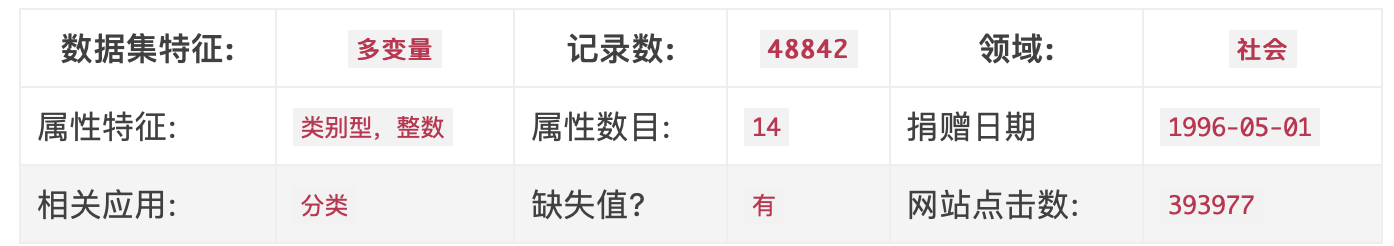

In [90]:
def read_data(data_path, header):

    #构造训练数据：读取数据集，添加列索引
    names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
             'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
             'native-country', 'target']
    data = pd.read_table(data_path, sep = ',', names = names, header = header)
    return data

#### 函数的使用
1）read_csv( ) 读取以‘，’分割的文件到DataFrame 

2）read_table( )读取以‘/t’分割的文件到DataFrame
##### 参数列表：
* sep：实质上是通用的，在实际使用中可以通过对sep参数的控制来对任何文本文件读取。文本中的分割符既有空格又有制表符（‘/t’），sep参数用‘/s+’，可以匹配任何空格。
* names：添加列索引，用index_col添加行索引
* header：用作列名的行号，默认为0（第一行），如果没有header则设置为None。

### 1.2 提取特征
对数据进行归一化、分箱、叉乘等操作后，构造wide模型和deep模型的数据，feature_engine(data)函数输出参数如下：
* x(wide_data, deep_data, target),
* deep_columns_idx={'col_name':index,...},
* embedding_columns_dict={'col_name':(unique_value_len, embedding_dimension)}

In [95]:
def feature_engine(data):
    # 构建模型的输出 target , <=50K 则 target = 0 否则 target = 1
    data['target'] = data['target'].apply(lambda x: 0 if x == ' <=50K' else 1)
    data_target = data['target']
    
    # 使用cut方法对 age 属性进行分箱
    bins = [-np.inf, 18, 25, 35, 45, 50, np.inf]
    labels = list(range(len(bins) - 1))
    data['age'] = pd.cut(data['age'], bins=bins, labels=labels)

    # education-num
    bins = [-np.inf, 5, 10, 20, 40, np.inf]
    labels = list(range(len(bins) - 1))
    data['education-num'] = pd.cut(data['education-num'], bins=bins, labels=labels)

    # hours-per-week
    bins = [-np.inf, 10, 30, 40, 70, np.inf]
    labels = list(range(len(bins) - 1))
    data['hours-per-week'] = pd.cut(data['hours-per-week'], bins=bins, labels=labels)
    
    # 分为3个continuos features 和 10个categorical features，本来是6:7
    # 上面将'age', 'hours-per-week', 'education-num'三种属性转换为类别特征
    # 我理解为：想通过叉乘的方式组合以上三种特征和其他7种类别特征，作为wide模型的输入
    continuous_cols = ['fnlwgt', 'capital-gain', 'capital-loss']
    categorical_cols = [col for col in data.columns if
                   col not in continuous_cols + ['age', 'hours-per-week', 'education-num']]
    
    # fit_transform 以后，这一列离散型数据就变成了 [0,  n-1] 这个区间的数
    # 这里 n 是一个列表的不同取值的个数，可以认为是某个特征的所有不同取值的个数。
    for col in categorical_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
    
    # preprocessing.MinMaxScalar()将数据归一化到[0,1]
    # pd.reshape()是数组array中的方法，作用是将数据重新组织,新生成数组和原数组公用一个内存，不管改变哪个都会互相影响。
    # reshape(-1) 和 reshape(1,-1) 将数组横向平铺，reshape(-1,1)将数组纵向平铺
    for col in continuous_cols:
        mms = MinMaxScaler()
        data[col] = mms.fit_transform(data[col].values.reshape(-1, 1)).reshape(-1)
    
    # 构建wide模型的数据 data_wide
    wide_columns = ['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship',
                    'hours-per-week', 'native-country', 'marital-status', 'sex']
    data_wide = data[wide_columns]
    
    # 构建组合特征，也验证了我前文对于把'age'、'hours-per-week'、'education-num'转化为类别特征的原因的猜想
    cross_columns = [['occupation', 'sex'], ['occupation', 'education'], ['education', 'native-country'],
                     ['age', 'occupation'], ['age', 'hours-per-week'], ['sex', 'education']]
    
    # PolynomialFeatures()使用多项式方法进行特征构建
    # 如果有a，b两个特征，那么它的2次多项式为（1,a,b,a^2,ab, b^2），这个多项式的形式是使用poly的效果
    # pd.DataFrame(data, index, column)可以根据dict以及读取csv或者txt文件来创建表格型数据
    # pd.concat函数可以将数据根据不同的轴作简单的融合
    for col in cross_columns:
        poly = PolynomialFeatures()
        c = poly.fit_transform(data_wide[col])
        c = pd.DataFrame(c, columns=[col[0] + '_' + col[1] + '_{}'.format(i) for i in range(c.shape[1])])
        data_wide = pd.concat((data_wide, c), axis=1)

    # pd.get_dummies()进行one-hot编码
    # Series里的整数会按照one-hot进行编码，但是在DataFrame里面不会进行编码，因此将整数类型都用astype('str')转成字符串类型
    for col in wide_columns:
        data_wide[col] = data_wide[col].astype('str')
    data_wide = pd.get_dummies(data_wide)

    # 构建embedding dict
    deep_columns = ['workclass', 'occupation', 'native-country', 'race', 'fnlwgt', 'capital-gain', 'capital-loss']
    data_deep = data[deep_columns]
    # 对deep模型输入特征中的 类别特征 进行embedding
    embedding_columns = ['workclass', 'occupation', 'native-country', 'race']
    embedding_columns_dict = {}
    for i in range(len(deep_columns)):
        if deep_columns[i] in embedding_columns:
            col_name = deep_columns[i]
            embedding_columns_dict[col_name] = (len(data_deep[col_name].unique()), 8)
    #  字典deep_columns_idx用于存放data_deep数据的索引，例：表头为 key='workclass' 的特征为data_deep的第 idx=1 列
    deep_columns_idx = dict()
    for idx, key in enumerate(data_deep.columns):
        deep_columns_idx[key] = idx
    # deep_columns_idx={'col_name':index,...},
    # embedding_columns_dict={'col_name':(unique_value_len, embedding_dimension)}
    
    # 划分训练集和验证集，random_state为随机数种子，都设置为999，才能产生同样编号的随机数，widemodel/deepmodel/target数据才能对应
    train_wide, test_wide = train_test_split(data_wide, test_size=0.4, random_state=999)
    train_deep, test_deep = train_test_split(data_deep, test_size=0.4, random_state=999)
    train_target, test_target = train_test_split(data_target, test_size=0.4, random_state=999)
    train, test = (train_wide, train_deep, train_target), (test_wide, test_deep, test_target)
    return train, test, deep_columns_idx, embedding_columns_dict

#### 函数的使用：

1）apply(func, axis)：可以对DataFrame对象进行操作，既可以作用于一行或者一列的元素，也可以作用于单个元素。示例：行操作 data.apply(func, axis = 1)，列操作 data.apply(func)。

2）pd.cut(data[column_name], bins, labels)：进行分箱操作。示例：pd.cut(data[column_name], bins, labels)
* bins是分箱区间
* label是每个区间的标签。

3）preprocessing.MinMaxScaler( )：归一化，属性缩放到一个指定的最大和最小值（通常是1-0）之间，常用的最小最大规范化方法$(x-min(x))/(max(x)-min(x))$，在构造类对象的时候也可以直接指定最大最小值的范围：feature_range=(min, max)，此时应用的公式变为：$X_{scaled}=X_{std}/(max-min)+min$
作用：对于方差非常小的属性可以增强其稳定性；维持稀疏矩阵中为0的条目。

4）pd.reshape(row_num, col_num)： 可以根据指定的数值将数据转换为特定的行数和列数，这个好理解，就是转换成矩阵。而reshape(-1, 1)或reshape(1, -1)中的含义是什么呢？这里的-1被理解为unspecified value，意思是未指定为给定的。如果我只需要特定的行数，列数多少我无所谓，我只需要指定行数，那么列数直接用-1代替就行了，计算机帮我们算共有多少列，反之亦然。所以-1在这里应该可以理解为一个正整数通配符，它代替任何整数。

5）pd.concat(objs, axis=0, join='outer', join_axes=None, ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False)可以将数据根据不同的轴作简单的融合
* objs: series，dataframe或者是panel构成的序列lsit 
* axis： 需要合并链接的轴，0是行，1是列 
* join：连接的方式 inner，或者outer

6）pd.getdummies(data, prefix=[args])：根据args的数目进行编码，示例：pd.get_dummies(df, prefix=['A','B'])。

7）sklearn.model_selection.train_test_split随机划分训练集和测试集，形式为：
X_train,X_test, y_train, y_test = cross_validation.train_test_split(train_data,train_target,test_size=0.4, random_state=0)
* train_data：所要划分的样本特征集
* train_target：所要划分的样本结果
* test_size：样本占比，如果是整数的话就是样本的数量
* random_state：是随机数的种子，其实就是该组随机数的编号，在需要重复试验的时候，保证得到一组一样的随机数。比如你每次都填1，其他参数一样的情况下你得到的随机数组是一样的。但填None，每次都会不一样。随机数的产生取决于种子，随机数和种子之间的关系遵从以下两个规则：种子不同，产生不同的随机数；种子相同，即使实例不同也产生相同的随机数。

## 2. 模型构建
### 2.1 模型构建的一些工具定义

In [96]:
import torch.nn.functional as F
import torch
import torch.nn as nn

In [97]:
def set_method(task):
    """
    select loss function for diff task
    :param task: str
        the type of task.
        e.g.'regression' or 'binary' or 'multiclass'
    :return different unlinear function and loss function
    """
    if task == 'regression':
        return None, F.mse_loss
    if task == 'binary':
        return torch.sigmoid, F.binary_cross_entropy
    if task == 'multiclass':
        return F.softmax, F.cross_entropy

In [98]:
# save model的问题，保存整个模型及参数，如果模型很大加载的时候会很慢，不适用与在线预测，在线预测一般是只将模型参数保存及model.state_dict
# 如果实现的是模型的继续训练，则需要同时保存优化器和当前训练的epoch，不保存epoch的话每次训练依然是从第epoch=0开始训练
# 在线预测的时候需要先定义好网络结构，然后load网络参数进行预测即可
def save_model(model, path):
    """
    save model params
    """
    torch.save(model.state_dict(), path)

In [99]:
# 参数model是事先定义好的网络模型
def load_model(model, path):
    """
    load model
    """
    model.load_state_dict(torch.load(path))

In [100]:
def to_device():
    """
    user gpu or cpu
    """
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2.2 The wide component 构建
** wide model for categorical features and cross features **

the wide model is complemented by LR, so the features are manual crossed.

In [101]:
class WideModel(nn.Module):
    def __init__(self, d_input, d_output = 0):
        """
        The Wide Component using LR
        :param d_input: int 
            the dimension of wide model input
        :param d_output: int 
            the dimension of wide model output
        """
        # 继承 Module 的 __init__ 功能
        super(WideModel, self).__init__()     
        # 定义每层用什么样的形式
        self.linear = nn.Linear(d_input, d_output)
        
    def forward(self, x):
        out = self.linear(x)
        return out

#### 函数的使用：
PyTorch的nn.Linear（ ）用于对输入数据进行线性变换，$y=xA^T+b$，需要注意的是全连接层的输入与输出都是二维张量，一般形状为[batch_size, size]，其用法与形参说明如下：torch.nn.Linear(in_featurea, out_features, bias = True)
* in_features指的是输入的二维张量的大小，即输入的[batch_size, size]中的size。
* out_features指的是输出的二维张量的大小，即输出的二维张量的形状为[batch_size，output_size]，当然，它也代表了该全连接层的神经元个数。

从输入输出的张量的shape角度来理解，相当于一个输入为[batch_size, in_features]的张量变换成了[batch_size, out_features]的输出张量。

### 2.3 The deep component 构建

In [102]:
class DeepModel(nn.Module):
    def __init__(self, deep_columns_idx, embedding_columns_dict,  hidden_layers, dropouts, output_dim):
        """
        init parameters
        :param deep_columns_idx: dict 
            include column name and it's index
            e.g. {'age': 0, 'career': 1,...}
        :param embedding_columns_dict: dict 
            include categories columns name and number of unique val and embedding dimension
            e.g. {'age':(10, 32),...}
        :param hidden_layers: list number of hidden layers
            List with the number of neurons per dense layer. 
            e.g: [64,32]
        :param deep_columns_idx: dict
            dict of columns name and columns index
        :param dropouts: list of float 
            each hidden layers dropout len(dropouts) == hidden_layers - 1
        :param output_dom: int
            the output_dim attribute will be used as input_dim when "merging" the models       
        """
        super(DeepModel, self).__init__()
        self.embedding_columns_dict = embedding_columns_dict
        self.deep_columns_idx = deep_columns_idx
        
        # categories feature --> embedding
        # val[0]: number of unique val
        # val[1]: embedding dimension
        for key, val in embedding_columns_dict.items():
            setattr(self, 'dense_col_' + key, nn.Embedding(val[0], val[1]))
        
        # compute the dim of embedding_layer : embedding_layer_dim，即continuous_dim + categorical_dim
        # the dimension of categorical feature : embedding_columns_dict[col][1], 即the number of unique val
        # the dimension of each continuous feature is 1
        embedding_layer_dim = 0
        for col in self.deep_columns_idx.keys():
            if col in embedding_columns_dict:
                embedding_layer_dim += embedding_columns_dict[col][1]
            else:
                embedding_layer_dim += 1

        # 定义每层用什么样的形式               
        self.layers = nn.Sequential()
        hidden_layers = [embedding_layer_dim] + hidden_layers
        dropouts = [0.0] + dropouts
        for i in range(1, len(hidden_layers)):
            self.layers.add_module(
                'hidden_layer_{}'.format(i-1),
                nn.Sequential(nn.Linear(hidden_layers[i-1], hidden_layers[i]),
                nn.LeakyReLU(),
                nn.Dropout(dropouts[i-1]))
            )
            
        self.layers.add_module('last_linear', nn.Linear(hidden_layers[-1], output_dim))
        
    def forward(self, x):
        emb = []
        continuous_cols = [col for col in self.deep_columns_idx.keys() if col not in self.embedding_columns_dict]
        for col, _ in self.embedding_columns_dict.items():
            if col not in self.deep_columns_idx:
                raise ValueError("ERROR column name may be your deep_columns_idx dict is not math the"
                                 "embedding_columns_dict")
            else:
                idx = self.deep_columns_idx[col]
                emb.append(getattr(self, 'dense_col_' + col)(x[:, idx].long()))

        for col in continuous_cols:
            idx = self.deep_columns_idx[col]
            emb.append(x[:, idx].view(-1, 1).float())
        embedding_layers = torch.cat(emb, dim=1) 
        out = self.layers(embedding_layers)
        return out

#### 函数的使用:
1）Python 字典 items() 方法以列表返回可遍历的(键, 值) 元组数组。形式：dict.items()

2）torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2, scale_grad_by_freq=False, sparse=False)
这个模块常用来保存词嵌入和用下标检索它们。模块的输入是一个下标的列表，输出是对应的词嵌入。
I think this is just an initial embedding, this embedding can be adjusted along with the training procedure. You can also treat it as word2vec. This embedding is continuous, while the one-hot is discrete.

3）torch.cat(list, dim)将多个张量（tensor）拼接在一起，cat是concatnate的意思，即拼接，联系在一起。list中的矩阵维数数值需相同，方能对齐。

### 2.4 The wide&deep 模型构建

In [103]:
class WideDeep(nn.Module):
    def __init__(self, wide_model_params, deep_model_params, activation):
        """
        init parameters of wide deep model
        :param wide_model_params: dict 
            parameters for set wide model
        :param deep_model_params: dict 
            parameters for set deep model
        :param activation: 
            activation function for model
        """
        super(WideDeep, self).__init__()
        self.activation = activation

        # wide model parameters
        wide_input_dim = wide_model_params['wide_input_dim']
        wide_output_dim = wide_model_params['wide_output_dim']
        self.wide = WideModel(wide_input_dim, wide_output_dim)

        # deep model parameters
        deep_columns_idx = deep_model_params['deep_columns_idx']
        embedding_columns_dict = deep_model_params['embedding_columns_dict']
        hidden_layers = deep_model_params['hidden_layers']
        dropouts = deep_model_params['dropouts']
        deep_output_dim = deep_model_params['deep_output_dim']
        self.deep = DeepModel(deep_columns_idx = deep_columns_idx,
                              embedding_columns_dict = embedding_columns_dict,
                              hidden_layers = hidden_layers,
                              dropouts = dropouts,
                              output_dim = deep_output_dim)

    def forward(self, x):
        """
        input and forward
        :param x: tuple(wide_model_data, deep_model_data, target)
        :return:
        """
        # wide model
        wide_data = x[0]
        wide_out = self.wide(wide_data.float())

        # deep model
        deep_data = x[1]
        deep_out = self.deep(deep_data)

        assert wide_out.size() == deep_out.size()
        wide_deep = wide_out.add(deep_out)
        if not self.activation:
            return wide_deep
        elif self.activation == F.softmax:
            out = self.activation(wide_deep, dim=1)
        else:
            out = self.activation(wide_deep)
        return out

## 3. 训练模型
### 3.1 读取训练集

In [104]:
class trainset(Dataset):
    '''
    WideDeepDataset object that will be loaded
    '''
    def __init__(self, data):
        self.wide_data = data[0]
        self.deep_data = data[1]
        self.target = data[2]

    def __getitem__(self, index):
        wide_data = self.wide_data[index]
        deep_data = self.deep_data[index]
        target = self.target[index]
        data = (wide_data, deep_data, target)
        return data

    def __len__(self):
        return len(self.target)

### 3.2 训练和验证轮次

In [105]:
from sklearn.metrics import accuracy_score

In [106]:
def valid_epoch(model, valid_loader, criterion, device):
    model.eval()
    losses = []
    targets = []
    outs = []
    for idx, (data_wide, data_deep, target) in enumerate(valid_loader):
        data_wide, data_deep, target = data_wide.to(device), data_deep.to(device), target.to(device)
        x = (data_wide, data_deep)
        out = model(x)
        loss = criterion(out, target.float())
        losses.append(loss.item())
        targets += list(target.numpy())
        out = out.view(-1).detach().numpy()
        outs += list(np.int64(out > 0.5))
    met = accuracy_score(targets, outs)
    return met, sum(losses) / len(losses)

def train_epoch(model, train_loader, optimizer, criterion, device, epoch, print_step):
    model.train()
    for idx, (data_wide, data_deep, target) in enumerate(train_loader):
        data_wide, data_deep, target = data_wide.to(device), data_deep.to(device), target.to(device)
        x = (data_wide, data_deep)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, target.float())
        loss.backward()
        optimizer.step()

        if (idx + 1) % print_step == 0:
            print("Epoch %d iteration %d loss is %.4f" % (epoch+1, idx+1, loss.item()))
        if idx == len(train_loader):
            break

#### 函数的使用：
1）optimizer.zero_grad(): 对应 d_weights = [0] * n
即将梯度初始化为零（因为一个batch的loss关于weight的导数是所有sample的loss关于weight的导数的累加和）

In [107]:
def train(model, train_loader, test_loader, optimizers, criterion, device, epochs,  print_step, validation=True):
    for epoch in range(epochs):
        train_epoch(model, train_loader, optimizers, criterion, device, epoch, print_step)

        if validation:
            met, loss = valid_epoch(model, test_loader, criterion, device)
            print("Epoch %d validation loss is %.4f and validation metrics is %.4f" % (epoch + 1, loss, met))


In [108]:
import argparse
import time
import warnings
warnings.filterwarnings("ignore")

In [109]:
def main(args):
    #构造存放数据集的路径“./data/adult/adult.data”路径
    path = os.path.abspath('.')
    data_path = os.path.join(path, 'data/adult', 'adult.data')
    data = read_data(data_path, None)
    train_data, test_data, deep_columns_idx, embedding_columns_dict = feature_engine(data)
    data_wide = train_data[0]
    train_data = (torch.from_numpy(train_data[0].values), torch.from_numpy(train_data[1].values),
                  torch.from_numpy(train_data[2].values))
    train_data = trainset(train_data)
    test_data = (torch.from_numpy(test_data[0].values), torch.from_numpy(test_data[1].values),
                 torch.from_numpy(test_data[2].values))
    test_data = trainset(test_data)
    trainloader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
    testloader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False)
    device = to_device()
    # parameters setting
    deep_model_params = {
        'deep_columns_idx': deep_columns_idx,
        'embedding_columns_dict': embedding_columns_dict,
        'hidden_layers': args.hidden_layers,
        'dropouts': args.dropouts,
        'deep_output_dim': args.deep_out_dim}
    wide_model_params = {
        'wide_input_dim': data_wide.shape[1],
        'wide_output_dim': args.wide_out_dim
    }
    activation, criterion = set_method(args.method)
    widedeep = WideDeep(wide_model_params, deep_model_params, activation)
    widedeep = widedeep.to(device)
    optimizer = torch.optim.Adam(widedeep.parameters(), lr=args.lr)
    train(widedeep, trainloader, testloader, optimizer, criterion, device, epochs=args.epochs,
          print_step=args.print_step, validation=args.validation)
    save_model(widedeep, "wide_deep_model_{}.pkl".format(time.time()))

if __name__ == "__main__":
    parse = argparse.ArgumentParser(description="wide deep model include arguments")
    parse.add_argument("--hidden_layers", nargs='+', type=int, default=[64, 32, 16])
    parse.add_argument("--dropouts", nargs='+', type=int, default=[0.5, 0.5])
    parse.add_argument("--deep_out_dim", default=1, type=int)
    parse.add_argument("--wide_out_dim", default=1, type=int)
    parse.add_argument("--batch_size", default=32, type=int)
    parse.add_argument("--lr", default=0.01, type=float)
    parse.add_argument("--print_step", default=200, type=int)
    parse.add_argument("--epochs", default=10, type=int)
    parse.add_argument("--validation", default=True, type=bool)
    parse.add_argument("--method", choices=['multiclass', 'binary', 'regression'], default='binary',type=str)
    args = parse.parse_known_args()[0]
    main(args)


Epoch 1 iteration 200 loss is 0.5976
Epoch 1 iteration 400 loss is 0.2172
Epoch 1 iteration 600 loss is 0.5513
Epoch 1 validation loss is 0.6857 and validation metrics is 0.7998
Epoch 2 iteration 200 loss is 0.3889
Epoch 2 iteration 400 loss is 1.3663
Epoch 2 iteration 600 loss is 0.7999
Epoch 2 validation loss is 1.3566 and validation metrics is 0.7633
Epoch 3 iteration 200 loss is 0.7899
Epoch 3 iteration 400 loss is 0.6095
Epoch 3 iteration 600 loss is 1.1987
Epoch 3 validation loss is 0.7377 and validation metrics is 0.8130
Epoch 4 iteration 200 loss is 0.5770
Epoch 4 iteration 400 loss is 0.5620
Epoch 4 iteration 600 loss is 0.2760
Epoch 4 validation loss is 0.4091 and validation metrics is 0.8377
Epoch 5 iteration 200 loss is 0.4375
Epoch 5 iteration 400 loss is 0.2463
Epoch 5 iteration 600 loss is 0.6650
Epoch 5 validation loss is 0.4624 and validation metrics is 0.8319
Epoch 6 iteration 200 loss is 0.4393
Epoch 6 iteration 400 loss is 1.0667
Epoch 6 iteration 600 loss is 1.1354

## 4. 预测

In [110]:
parse = argparse.ArgumentParser(description="wide deep model include arguments")
parse.add_argument("--hidden_layers", nargs='+', type=int, default=[64, 32, 16])
parse.add_argument("--dropouts", nargs='+', type=int, default=[0.5, 0.5])
parse.add_argument("--deep_out_dim", default=1, type=int)
parse.add_argument("--wide_out_dim", default=1, type=int)
parse.add_argument("--batch_size", default=32, type=int)
parse.add_argument("--lr", default=0.01, type=float)
parse.add_argument("--print_step", default=200, type=int)
parse.add_argument("--epochs", default=10, type=int)
parse.add_argument("--validation", default=True, type=bool)
parse.add_argument("--method", choices=['multiclass', 'binary', 'regression'], default='binary',type=str)
args = parse.parse_known_args()[0]
#构造存放数据集的路径“./data/adult/adult.data”路径
path = os.path.abspath('.')
pre_data_path = os.path.join(path, 'data/adult', 'adult.data')
data = read_data(pre_data_path, None)
train_data, test_data, deep_columns_idx, embedding_columns_dict = feature_engine(data)
data_wide = train_data[0]

# 预测数据的输入格式，这里预测一条数据
t = (torch.from_numpy(train_data[0].values[0].reshape(-1, train_data[0].values.shape[1])),
     torch.from_numpy(train_data[1].values[0].reshape(-1, train_data[1].values.shape[1])))
print(t)

# parameters setting
deep_model_params = {
    'deep_columns_idx': deep_columns_idx,
    'embedding_columns_dict': embedding_columns_dict,
    'hidden_layers': args.hidden_layers,
    'dropouts': args.dropouts,
    'deep_output_dim': args.deep_out_dim}
wide_model_params = {
    'wide_input_dim': data_wide.shape[1],
    'wide_output_dim': args.wide_out_dim
}
activation, criterion = set_method(args.method)
widedeep = WideDeep(wide_model_params, deep_model_params, activation)
# path 为存储模型参数的位置
path = 'wide_deep_model_1584770777.30368.pkl'
load_model(widedeep, path)
print(widedeep(t))


(tensor([[1.0000e+00, 7.0000e+00, 1.0000e+00, 4.9000e+01, 7.0000e+00, 1.0000e+00,
         1.0000e+00, 7.0000e+00, 1.5000e+01, 4.9000e+01, 1.0500e+02, 2.2500e+02,
         1.0000e+00, 1.5000e+01, 3.9000e+01, 2.2500e+02, 5.8500e+02, 1.5210e+03,
         1.0000e+00, 5.0000e+00, 7.0000e+00, 2.5000e+01, 3.5000e+01, 4.9000e+01,
         1.0000e+00, 5.0000e+00, 1.0000e+00, 2.5000e+01, 5.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.5000e+01, 1.0000e+00, 1.5000e+01, 2.2500e+02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000